# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
'''
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git''
'''

'\n!python -m pip install pyyaml==5.1\nimport sys, os, distutils.core\n# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).\n# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions\n!git clone \'https://github.com/facebookresearch/detectron2\'\ndist = distutils.core.run_setup("./detectron2/setup.py")\n!python -m pip install {\' \'.join([f"\'{x}\'" for x in dist.install_requires])}\nsys.path.insert(0, os.path.abspath(\'./detectron2\'))\n\n# Properly install detectron2. (Please do not install twice in both ways)\n# !python -m pip install \'git+https://github.com/facebookresearch/detectron2.git\'\'\n'

In [2]:
!python --version

Python 3.12.7


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [4]:
def coco_label_from_index(index):
    """
    주어진 인덱스를 COCO 라벨 텍스트로 변환합니다.
    index가 0이면 'background', 1~80이면 각각 COCO 객체 라벨을 반환합니다.
    """
    coco_labels = [
        #"background",  # 0
        "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
        "truck", "boat", "traffic light", "fire hydrant", "stop sign",
        "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
        "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
        "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
        "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
        "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
        "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
        "couch", "potted plant", "bed", "dining table", "toilet", "tv",
        "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave",
        "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
        "scissors", "teddy bear", "hair drier", "toothbrush"
    ]
    if 0 <= index < len(coco_labels):
        return coco_labels[index]
    else:
        return "Invalid index"

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
def cv2_imshow(img):
    """Display an image using OpenCV in a Jupyter notebook."""
    if isinstance(img, np.ndarray):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

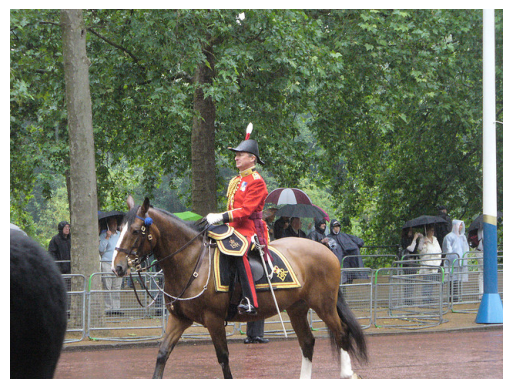

In [6]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
#plt.imshow(im)
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [7]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6 # set IoU threshold
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[03/31 05:49:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/opt/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
# 출력의 예시를보자, 바운딩박스와 클래스 및 매핑을 출력하여 정성적으로 모델이 정상동작함을 확인함.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

labels_pred = outputs["instances"].pred_classes.cpu().numpy()
print(labels_pred)
 
rawpred = []
for i in range(len(labels_pred)):
  rawpred.append(coco_label_from_index(labels_pred[i]))

print(rawpred)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6011, 244.9034, 459.8285, 480.0000],
        [251.1036, 157.8121, 338.9755, 413.6360],
        [114.8530, 268.6880, 148.2364, 398.8153],
        [  0.8219, 281.0366,  78.6029, 478.4252],
        [ 49.3947, 274.1254,  80.1547, 342.9856],
        [561.2262, 271.5816, 596.2767, 385.2566],
        [385.9050, 270.3108, 413.7125, 304.0394],
        [515.9247, 278.3727, 562.2798, 389.3832],
        [335.2405, 251.9170, 414.7483, 275.9344],
        [350.9267, 269.2094, 386.0968, 297.9085],
        [331.6260, 230.9999, 393.2771, 257.2016],
        [510.7302, 263.2703, 570.9870, 295.9433],
        [522.7950, 279.4763, 562.1108, 346.9972],
        [409.0875, 271.8648, 460.5588, 356.8723],
        [506.8879, 283.3307, 529.9493, 324.0259],
        [594.5669, 283.4807, 609.0570, 311.4136]], device='cuda:0'))
[17  0  0  0  0  0  0  0 25  0 25 25  0  0  0 24]
['horse', 'person', 'person'

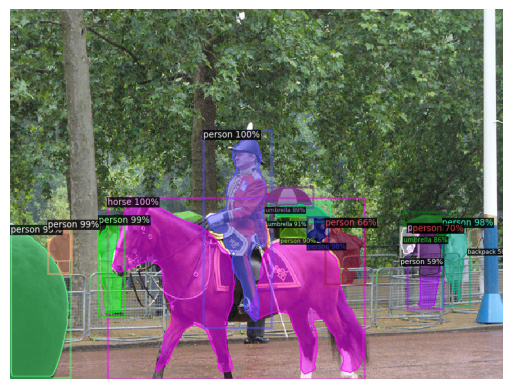

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
# 예측에 대한 시각화도 기본적으로 튜토리얼에서 제공한다.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
# Hook을 사용하여 logits 추출
class LogitsHook:
    def __init__(self):
        #self.logits = None  # Raw logits 저장
        self.logits = []  # Raw logits 저장

    def __call__(self, module, inputs, outputs):
        #self.logits = outputs[0]  # ROI-Head의 logits 저장
        self.logits.append(outputs.clone())

hook = LogitsHook()
predictor.model.roi_heads.box_predictor.cls_score.register_forward_hook(hook)

# 🔹 모델 실행
with torch.no_grad():
    outputs = predictor(im)  # Detectron2 실행



In [11]:
print(outputs["instances"])

Instances(num_instances=16, image_height=480, image_width=640, fields=[pred_boxes: Boxes(tensor([[126.6011, 244.9034, 459.8285, 480.0000],
        [251.1036, 157.8121, 338.9755, 413.6360],
        [114.8530, 268.6880, 148.2364, 398.8153],
        [  0.8219, 281.0366,  78.6029, 478.4252],
        [ 49.3947, 274.1254,  80.1547, 342.9856],
        [561.2262, 271.5816, 596.2767, 385.2566],
        [385.9050, 270.3108, 413.7125, 304.0394],
        [515.9247, 278.3727, 562.2798, 389.3832],
        [335.2405, 251.9170, 414.7483, 275.9344],
        [350.9267, 269.2094, 386.0968, 297.9085],
        [331.6260, 230.9999, 393.2771, 257.2016],
        [510.7302, 263.2703, 570.9870, 295.9433],
        [522.7950, 279.4763, 562.1108, 346.9972],
        [409.0875, 271.8648, 460.5588, 356.8723],
        [506.8879, 283.3307, 529.9493, 324.0259],
        [594.5669, 283.4807, 609.0570, 311.4136]], device='cuda:0')), scores: tensor([0.9997, 0.9957, 0.9915, 0.9882, 0.9861, 0.9839, 0.9769, 0.9717, 0.9061,
   

In [12]:
all_logits = torch.cat(hook.logits, dim=0)
print(f"Logits Shape: {all_logits.shape}")

probs = torch.softmax(all_logits, dim=-1)
print(f"Softmax Probability Shape: {probs.shape}")

probnp = probs.cpu().numpy()
print(f"Scores_np : {probnp.shape}")


Logits Shape: torch.Size([1000, 81])
Softmax Probability Shape: torch.Size([1000, 81])
Scores_np : (1000, 81)


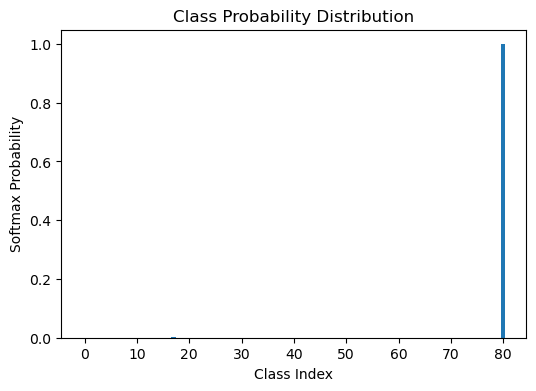

In [13]:
plt.figure(figsize=(6, 4))
plt.bar(range(len(probnp[999])), probnp[999])
plt.xlabel("Class Index")
plt.ylabel("Softmax Probability")
plt.title("Class Probability Distribution")
plt.show()

In [14]:
cls_pred_list = []

for i in range(len(probnp)):
    cls_pred_list.append(probnp[i].argmax())

print(cls_pred_list)

[0, 0, 0, 0, 25, 0, 25, 0, 0, 17, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 80, 0, 0, 80, 80, 25, 80, 17, 17, 25, 25, 0, 17, 0, 0, 0, 25, 0, 80, 25, 80, 25, 0, 0, 80, 0, 0, 80, 17, 80, 0, 80, 80, 0, 25, 80, 0, 80, 80, 80, 80, 25, 80, 0, 80, 80, 0, 25, 17, 80, 80, 0, 0, 80, 80, 0, 80, 0, 0, 80, 0, 80, 80, 80, 17, 80, 0, 0, 0, 80, 17, 80, 80, 80, 0, 0, 80, 0, 80, 80, 80, 0, 24, 80, 80, 0, 80, 80, 80, 0, 80, 17, 80, 0, 80, 0, 17, 80, 0, 80, 80, 0, 0, 80, 80, 80, 80, 0, 0, 0, 80, 80, 80, 0, 80, 0, 0, 0, 80, 80, 0, 0, 80, 0, 80, 80, 25, 80, 80, 0, 80, 80, 0, 80, 80, 80, 80, 0, 80, 0, 0, 80, 80, 80, 0, 80, 80, 80, 80, 80, 0, 80, 80, 80, 80, 0, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 0, 80, 17, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 17, 80, 0, 25, 0, 80, 25, 80, 80, 80, 80, 80, 80, 80, 80, 80, 0, 80, 80, 80, 80, 80, 80, 80, 0, 80, 0, 80, 80, 80, 80, 80, 80, 80, 80, 80, 0, 80, 80, 80, 0, 80, 0, 80, 80, 80, 0, 80, 80, 80, 80, 80, 80, 17, 8

In [15]:
cls_pred_indices = np.argmax(probnp, axis=1)
print(cls_pred_indices.shape)
cls_pred_scores = np.max(probnp, axis=1)
print(cls_pred_indices.shape)
# 예시로 각 객체에 대해 출력
#for i in range(probnp.shape[0]):
#    print(f"Object {i}: Predicted class = {cls_pred_indices[i]}, Score = {cls_pred_scores[i]}")





(1000,)
(1000,)


In [16]:
final_scores = outputs["instances"].scores.cpu().numpy()  # shape: (N_final,)

cls_pred_scores = np.atleast_1d(cls_pred_scores)
#print(cls_pred_scores)
final_scores = np.atleast_1d(final_scores)
print(final_scores)

remaining_indices = []
remaining_scores = []
used_pre_indices = set()

for final_score in final_scores:
    # 아직 매칭되지 않은 pre 단계 score 중 final_score와 근사치(isclose)를 만족하는 후보 찾기
    candidates = [i for i, score in enumerate(cls_pred_scores)
                  if np.isclose(score, final_score, atol=1e-8) and i not in used_pre_indices]
    if candidates:
        chosen = candidates[0]  # 첫 번째 후보 선택 (혹은 다른 기준 사용 가능)
        remaining_indices.append(chosen)
        remaining_scores.append(cls_pred_scores[chosen])
        used_pre_indices.add(chosen)

print("Remaining indices:", remaining_indices)
print("Remaining scores:", remaining_scores)
print("Number of final scores:", len(final_scores))

[0.9996723  0.9956916  0.9915059  0.9881728  0.9860656  0.98392916
 0.97691023 0.9716503  0.90610754 0.90370363 0.8868766  0.8576056
 0.70400125 0.65889215 0.588803   0.5768082 ]
Remaining indices: [9, 1, 5, 18, 3, 2, 21, 0, 33, 178, 6, 149, 22, 75, 163, 105]
Remaining scores: [0.9996723, 0.9956916, 0.9915059, 0.9881728, 0.9860656, 0.98392916, 0.97691023, 0.9716503, 0.90610754, 0.90370363, 0.8868766, 0.8576056, 0.70400125, 0.65889215, 0.588803, 0.5768082]
Number of final scores: 16


In [17]:
# 1. remaining_indices에 해당하는 softmax 분포만 필터링
filtered_probnp = probnp[remaining_indices]  # shape: (n, 81)

# 2. 각 객체의 최종 예측 클래스: softmax 분포의 argmax 값
final_predicted_classes = np.argmax(filtered_probnp, axis=1)  # shape: (n,)

# 3. 최종 bounding box 좌표: post-processing 결과에서 가져오기
final_bboxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()  # shape: (n, 4)

# 4. 최종 출력을 구조화 (인덱스 번호는 제거)
final_output_list = []
for i in range(len(final_predicted_classes)):
    final_output_list.append({
        "predicted_class": final_predicted_classes[i],
        "class_distribution": filtered_probnp[i],
        "bounding_box": final_bboxes[i]
    })

# 최종 결과 출력 (예시)
#for obj in final_output_list:
#    #print("Predicted Class:", obj["predicted_class"])
#    print("Predicted idx:", obj["predicted_class"])
#    print("predected class:", coco_label_from_index(obj["predicted_class"]))
#    #print("Class Distribution:", obj["class_distribution"]
#    print("Class Distribution:", obj["class_distribution"])
#    print("Bounding Box:", obj["bounding_box"])
#    print("-----")

In [18]:
for obj in final_output_list:
    distribution = obj["class_distribution"].copy()
    sorted_indices = np.argsort(distribution)[::-1]
    sorted_scores = distribution[sorted_indices]
    obj["sorted_class_indices"] = sorted_indices
    obj["sorted_class_scores"] = sorted_scores

In [19]:
#for i, obj in enumerate(final_output_list):
#    print(f"Object {i}:")
#    print("Sorted Class Indices:", obj["sorted_class_indices"])
#    print("Sorted Class Scores:", obj["sorted_class_scores"])
#    print("------")

In [20]:
for obj in final_output_list:
  sorted_scores = obj["sorted_class_scores"]
  cum_scores = np.cumsum(sorted_scores)
  obj["cum_cls_scores"] = cum_scores

#for i, obj in enumerate(final_output_list):
  #print(f"object {i}")
  #print("Sorted Class Scores:", obj["sorted_class_scores"])
  #print("Cumulative Class Scores:", obj["cum_cls_scores"])
  #print("-----")

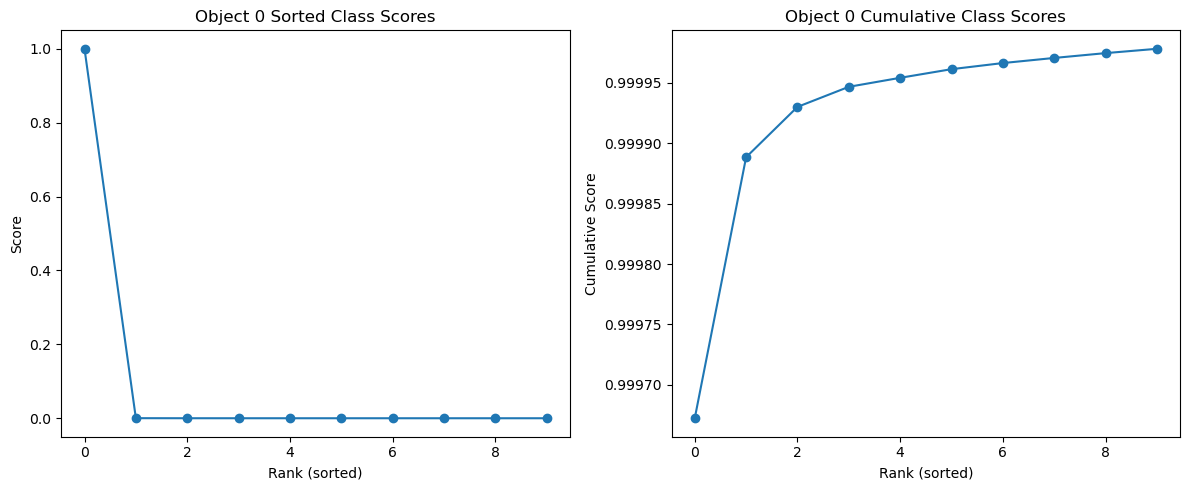

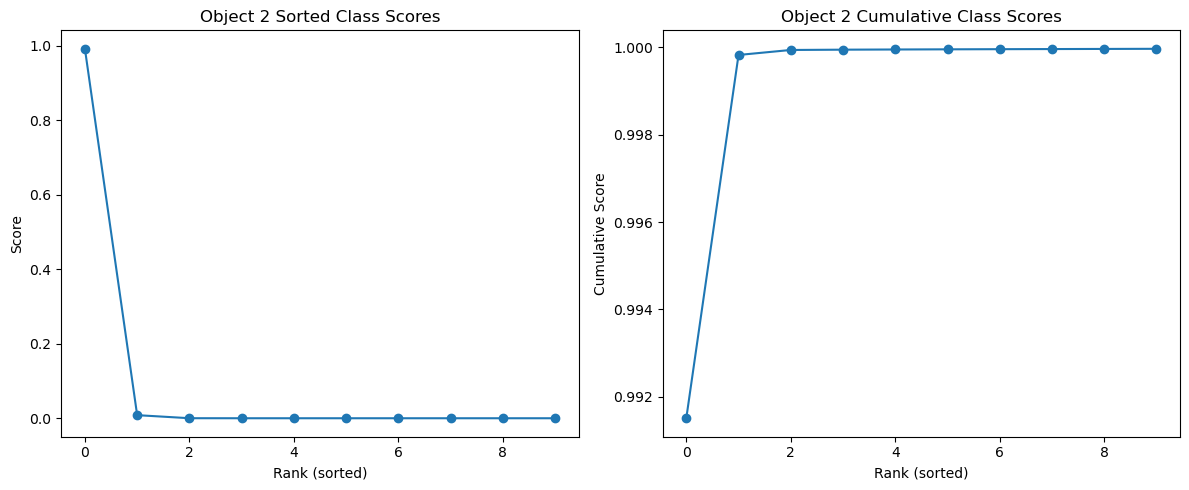

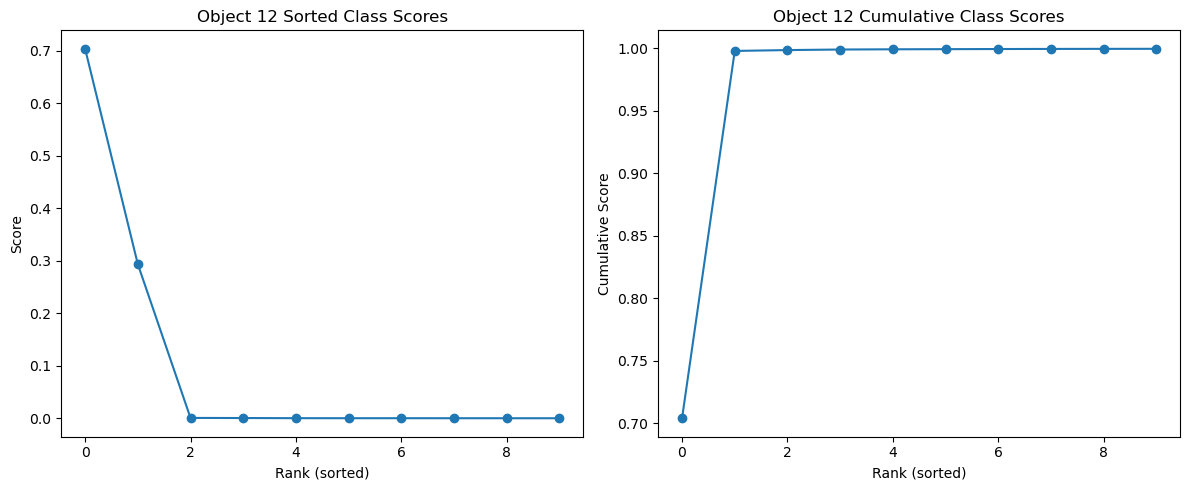

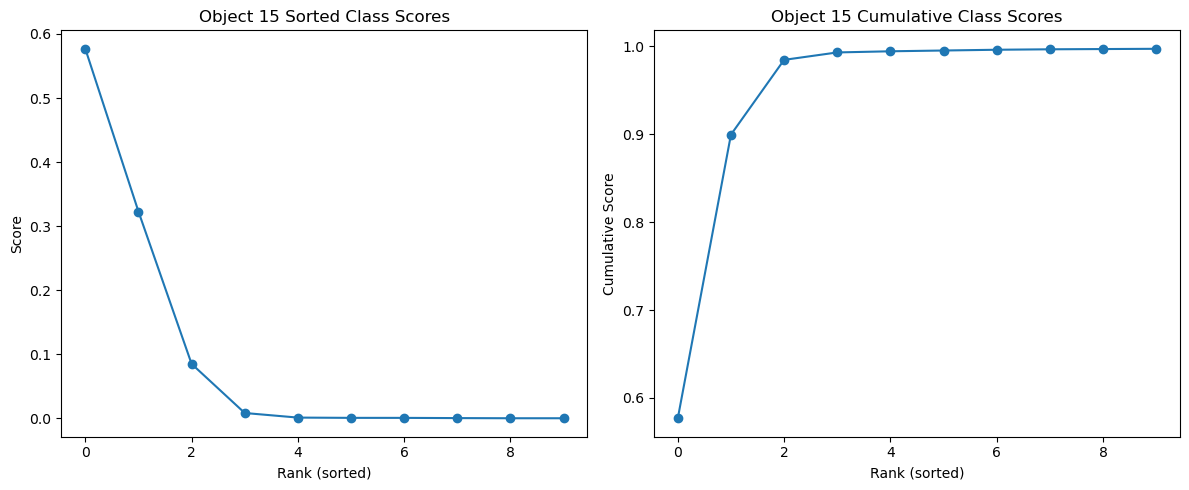

In [21]:
sample_indices = [0, 2, 12, 15]

for idx in sample_indices:
    obj = final_output_list[idx]
    sorted_scores = obj["sorted_class_scores"][:10]
    cum_scores = obj["cum_cls_scores"][:10]

    plt.figure(figsize=(12, 5))

    # 좌측: 내림차순 정렬된 클래스 스코어
    plt.subplot(1, 2, 1)
    plt.plot(sorted_scores, marker='o', linestyle='-')
    plt.title(f"Object {idx} Sorted Class Scores")
    plt.xlabel("Rank (sorted)")
    plt.ylabel("Score")

    # 우측: 누적 스코어
    plt.subplot(1, 2, 2)
    plt.plot(cum_scores, marker='o', linestyle='-')
    plt.title(f"Object {idx} Cumulative Class Scores")
    plt.xlabel("Rank (sorted)")
    plt.ylabel("Cumulative Score")

    plt.tight_layout()
    plt.show()

# Score Function
 - nonconformity_scores = np.abs(Y_pred_tensor - Y_test)

In [22]:
## example of qhat

## qhat derived from calibration dataset -> prediction -> score |ypred - ytest| -> sort
## and take np.quantile(ceil((n-1)(1-a))/n) as q_hat
q_hat = 0.90



In [23]:
for obj in final_output_list:
    prediction_set = []
    # sorted_class_indices와 cum_cls_scores는 이미 내림차순으로 정렬되어 있음
    for idx, cum_score in zip(obj["sorted_class_indices"], obj["cum_cls_scores"]):
        prediction_set.append(idx)
        # 누적 합계가 q_hat 이상이면 중단
        if cum_score >= q_hat:
            break
    obj["prediction_set"] = prediction_set

# 결과 확인 예시: 각 객체의 예측 집합 출력
for i, obj in enumerate(final_output_list):
    print(f"Object {i} Prediction Set: {obj['prediction_set']}")

Object 0 Prediction Set: [17]
Object 1 Prediction Set: [0]
Object 2 Prediction Set: [0]
Object 3 Prediction Set: [0]
Object 4 Prediction Set: [0]
Object 5 Prediction Set: [0]
Object 6 Prediction Set: [0]
Object 7 Prediction Set: [0]
Object 8 Prediction Set: [25]
Object 9 Prediction Set: [0]
Object 10 Prediction Set: [25, 80]
Object 11 Prediction Set: [25, 80]
Object 12 Prediction Set: [0, 80]
Object 13 Prediction Set: [0, 80]
Object 14 Prediction Set: [0, 80]
Object 15 Prediction Set: [24, 80, 0]


# Process Calibration Dataset

In [24]:
# Calibration Dataset을 얻기위해서, Test에 사용할 Validation Sset
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#!unzip annotations_trainval2017.zip

In [25]:
from pycocotools.coco import COCO

#ann_file = "annotations/instances_val2017.json"
ann_file = "/home/datasets/coco/annotations/instances_val2017.json"
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [26]:
import collections

class_to_images = collections.defaultdict(set)
ann_ids = coco.getAnnIds()
anns = coco.loadAnns(ann_ids)
for ann in anns:
  cat_id = ann['category_id']
  img_id = ann['image_id']
  class_to_images[cat_id].add(img_id)
for i in range(90):
  print(f"{i}클래스 이미지 수:", len(class_to_images[i]))

0클래스 이미지 수: 0
1클래스 이미지 수: 2693
2클래스 이미지 수: 149
3클래스 이미지 수: 535
4클래스 이미지 수: 159
5클래스 이미지 수: 97
6클래스 이미지 수: 189
7클래스 이미지 수: 157
8클래스 이미지 수: 250
9클래스 이미지 수: 121
10클래스 이미지 수: 191
11클래스 이미지 수: 86
12클래스 이미지 수: 0
13클래스 이미지 수: 69
14클래스 이미지 수: 37
15클래스 이미지 수: 235
16클래스 이미지 수: 125
17클래스 이미지 수: 184
18클래스 이미지 수: 177
19클래스 이미지 수: 128
20클래스 이미지 수: 65
21클래스 이미지 수: 87
22클래스 이미지 수: 89
23클래스 이미지 수: 49
24클래스 이미지 수: 85
25클래스 이미지 수: 101
26클래스 이미지 수: 0
27클래스 이미지 수: 228
28클래스 이미지 수: 174
29클래스 이미지 수: 0
30클래스 이미지 수: 0
31클래스 이미지 수: 292
32클래스 이미지 수: 145
33클래스 이미지 수: 105
34클래스 이미지 수: 84
35클래스 이미지 수: 120
36클래스 이미지 수: 49
37클래스 이미지 수: 169
38클래스 이미지 수: 91
39클래스 이미지 수: 97
40클래스 이미지 수: 100
41클래스 이미지 수: 127
42클래스 이미지 수: 149
43클래스 이미지 수: 167
44클래스 이미지 수: 379
45클래스 이미지 수: 0
46클래스 이미지 수: 110
47클래스 이미지 수: 390
48클래스 이미지 수: 155
49클래스 이미지 수: 181
50클래스 이미지 수: 153
51클래스 이미지 수: 314
52클래스 이미지 수: 103
53클래스 이미지 수: 76
54클래스 이미지 수: 98
55클래스 이미지 수: 85
56클래스 이미지 수: 71
57클래스 이미지 수: 81
58클래스 이미지 수: 51
59클래스 이미지 수: 153
60클래스 이미지 수: 62
61클래

In [27]:
print(class_to_images[1])

{532481, 458755, 385029, 311303, 393226, 532493, 8211, 327701, 188439, 434204, 401446, 213033, 466986, 213035, 319534, 516143, 32817, 532530, 188465, 434230, 475191, 254016, 131138, 16451, 81988, 376900, 507975, 434247, 204871, 516173, 122962, 98392, 442456, 32861, 213086, 442463, 311392, 311394, 49259, 221291, 442480, 368752, 319607, 417911, 32887, 450686, 32901, 270474, 139, 180383, 82085, 385190, 524456, 90284, 32941, 188592, 229553, 278705, 213171, 336053, 549055, 114884, 508101, 65736, 303305, 344268, 532690, 360661, 16598, 73946, 114907, 426203, 278749, 516318, 229601, 295138, 467176, 319721, 352491, 33005, 458992, 475387, 393469, 57597, 426241, 540932, 106757, 65798, 180487, 213255, 147725, 418062, 147729, 377113, 229659, 147740, 426268, 434459, 205105, 565563, 278848, 368961, 352582, 57672, 74058, 123213, 33104, 336209, 180560, 483667, 8532, 270677, 262487, 491867, 475484, 393569, 549220, 336232, 74092, 467315, 131444, 434548, 532855, 442746, 541055, 426376, 336265, 303499, 369

In [ ]:
### Validation dataset으로부터 Calibration set 생성. 이미지와 객체를 추출하기.
from pycocotools.coco import COCO
import os

def split_coco_annotations(annotation_file, image_folder):
    """
    COCO annotation 파일과 이미지 폴더를 입력받아,
    각 이미지에서 단일 객체(각 어노테이션)에 해당하는 샘플을 생성합니다.

    출력:
      single_object_dataset: 각 샘플은 이미지와 해당 객체의 bbox, category_id 등 정보를 포함하는 dict
    """
    coco = COCO(annotation_file)
    dataset = []
    img_ids = coco.getImgIds()

    for img_id in img_ids:
        # 이미지 정보 로드
        img_info = coco.loadImgs(img_id)[0]
        file_name = os.path.join(image_folder, img_info["file_name"])

        # 해당 이미지에 대한 모든 어노테이션 로드
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # 각 어노테이션을 단일 객체 샘플로 저장
        for ann in anns:
            record = {
                "image_id": img_id,
                "file_name": file_name,
                "height": img_info["height"],
                "width": img_info["width"],
                "bbox": ann["bbox"],             # [x, y, width, height]
                "category_id": ann["category_id"]  # 객체 클래스 번호
                # 추가 정보 (예: segmentation, area 등)도 필요에 따라 저장 가능
            }
            dataset.append(record)

    return dataset

# 예시 경로 (Colab 환경에서 경로가 다를 수 있음)
annotation_file = ann_file
image_folder = "val2017"

# 단일 객체 샘플 데이터셋 생성
single_object_dataset = split_coco_annotations(annotation_file, image_folder)
print("단일 객체 샘플 수:", len(single_object_dataset))

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
단일 객체 샘플 수: 36781


In [29]:
import random
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os


# COCO annotation 파일 경로 (예: instances_val2017.json)
#ann_file = "annotations/instances_val2017.json"
coco = COCO(ann_file)
# 카테고리 mapping (id → 이름)
cats = coco.loadCats(coco.getCatIds())
coco_categories = {cat['id']: cat['name'] for cat in cats}
sample_examples = random.sample(single_object_dataset, 10)


loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [30]:
for sample in sample_examples:

    # 바운딩 박스 정보: [x, y, width, height]
    x, y, w, h = sample["bbox"]
    x, y, w, h = int(x), int(y), int(w), int(h)

    # 카테고리 이름 얻기
    cat_id = sample["category_id"]
    label = coco_categories.get(cat_id, "Unknown")

    print(x,y,w,h)

219 371 21 3
355 305 59 82
298 90 341 389
454 202 30 65
524 268 4 4
154 373 147 65
625 166 14 30
260 48 65 104
1 97 26 39
560 274 38 89


In [31]:
print(single_object_dataset)

[{'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [217.62, 240.54, 38.99, 57.75], 'category_id': 44}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [1.0, 240.24, 346.63, 186.76], 'category_id': 67}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [388.66, 69.92, 109.41, 277.62], 'category_id': 1}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [135.57, 249.43, 22.32, 28.79], 'category_id': 49}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [31.28, 344.0, 68.12, 40.83], 'category_id': 51}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox': [59.63, 287.36, 76.07, 41.3], 'category_id': 51}, {'image_id': 397133, 'file_name': 'val2017/000000397133.jpg', 'height': 427, 'width': 640, 'bbox':

In [32]:
import json
output_file = "single_object_dataset.json"
with open(output_file, "w") as f:
  json.dump(single_object_dataset, f, indent=4)

print(f"Data successfully saved to {output_file}")

Data successfully saved to single_object_dataset.json


In [33]:
from detectron2.utils.visualizer import GenericMask
from detectron2.structures import BoxMode
from detectron2.data.datasets import load_coco_json
from detectron2.structures import BoxMode

def compute_iou(boxA, boxB):
    # standard IoU function
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea)

In [34]:
image_root = "/home/datasets/coco/val2017"
json_file = "/home/datasets/coco/annotations/instances_val2017.json"

val_dataset_dicts = load_coco_json(json_file, image_root, dataset_name="coco_val2017")

[03/31 05:49:36 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /home/datasets/coco/annotations/instances_val2017.json


In [36]:
calibration_scores = [] # calibration dataset의 score. adaptive set이 아님
cnt = 0

for data in val_dataset_dicts:
    if cnt % 500 == 0:
        print(f"processing data is : {data["file_name"]}, iter : {cnt}")
    cnt += 1
    
    img = cv2.imread(data["file_name"])
    outputs = predictor(img)

    pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    pred_scores = outputs["instances"].scores.cpu().numpy()
    pred_classes = outputs["instances"].pred_classes.cpu().numpy()

    gt_boxes = [BoxMode.convert(ann["bbox"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS) for ann in data["annotations"]]
    gt_classes = [ann["category_id"] for ann in data["annotations"]]

    matched_gt = set()  # 이미 매칭된 ground truth box의 인덱스
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_idx = -1
        for j, pred_box in enumerate(pred_boxes):
            if j in matched_gt:
                continue
            iou = compute_iou(gt_box, pred_box)
            if iou >= 0.5 and iou > best_iou:
                best_iou = iou
                best_idx = j
        if best_idx != -1:
            matched_gt.add(best_idx)
            score = pred_scores[best_idx]
            # Non-conformity score = 1 - P(y | x)
            calibration_scores.append(1 - score)
        

processing data is : /home/datasets/coco/val2017/000000000139.jpg, iter : 0
processing data is : /home/datasets/coco/val2017/000000057027.jpg, iter : 500
processing data is : /home/datasets/coco/val2017/000000119365.jpg, iter : 1000
processing data is : /home/datasets/coco/val2017/000000173091.jpg, iter : 1500
processing data is : /home/datasets/coco/val2017/000000229753.jpg, iter : 2000
processing data is : /home/datasets/coco/val2017/000000289594.jpg, iter : 2500
processing data is : /home/datasets/coco/val2017/000000347544.jpg, iter : 3000
processing data is : /home/datasets/coco/val2017/000000405249.jpg, iter : 3500
processing data is : /home/datasets/coco/val2017/000000463174.jpg, iter : 4000
processing data is : /home/datasets/coco/val2017/000000521601.jpg, iter : 4500


In [ ]:
### validation dataset 5000개에 대한 모든 object 3만개에 대한 score를 추출함
# 추출된 Score를 바탕으로 Calibration Dataset을 생성함
# 1. score를 sort함
# 2. n-1개에 대한 quantile을 구함 : 95% 번째의 분위수
# 3. 계산한 분위수를 threshold로 사용함. : q_hat
# 4. 누적합이 q_hat이 될때까지 클래스를 포함시킴


In [37]:
print(len(calibration_scores))

24494


In [55]:
calibration_scores = np.array(calibration_scores)
print(calibration_scores.shape)
print(calibration_scores[:-10])

(24494,)
[0.00593388 0.07969689 0.02523732 ... 0.16428697 0.00428975 0.10539466]


In [56]:
sorted_score = np.sort(calibration_scores)
alpha = 0.05
n = len(sorted_score)
quantile_index = int(np.ceil((1 - alpha) * (n + 1))) - 1 # 0-based index

#quantile_index = int(np.ceil((n + 1) * (1 - alpha)/n))
q_hat = sorted_score[quantile_index]
print(f"q_hat: {q_hat}, n = {n}, quantile_index = {quantile_index}")

q_hat: 0.43389320373535156, n = 24494, quantile_index = 23270


In [57]:
print(sorted_score[:10], n, quantile_index, q_hat)

[6.19888306e-05 7.03334808e-05 8.04662704e-05 8.78572464e-05
 9.64403152e-05 9.91821289e-05 1.05381012e-04 1.09076500e-04
 1.18613243e-04 1.19447708e-04] 24494 23270 0.43389320373535156


In [58]:
### extracted q_hat : 0.43389

[03/31 06:24:44 d2.data.datasets.coco]: Loaded 5000 images in COCO format from /home/datasets/coco/annotations/instances_val2017.json


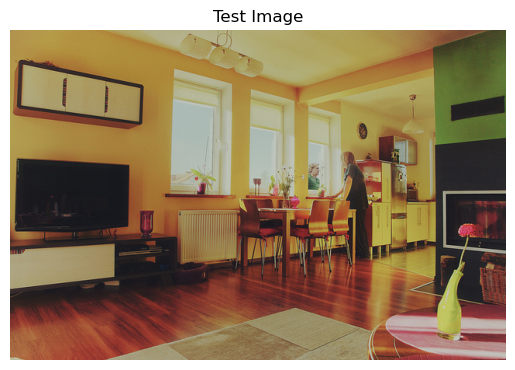

In [69]:
from detectron2.data.datasets import load_coco_json
import cv2
import matplotlib.pyplot as plt

# COCO validation 이미지 루트와 annotation 경로
test_image_root = "/home/datasets/coco/val2017"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"

# validation dataset 중 하나 불러오기
test_dataset_dicts = load_coco_json(test_json_file, test_image_root, dataset_name="coco_val2017")
test_sample = test_dataset_dicts[0]

# 이미지 로드 및 출력
image_path = test_sample["file_name"]
test_image = cv2.imread(image_path)
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.imshow(test_image_rgb)
plt.title("Test Image")
plt.axis("off")
plt.show()

In [87]:
conformal_out = predictor(test_image)
# 예측 결과
#print(conformal_out["instances"])
#print(conformal_out["instances"].scores)
print(conformal_out["instances"].pred_classes)
#output_classes = coco_label_from_index(conformal_out["instances"].pred_classes.item())
for i in range(len(conformal_out["instances"].pred_classes)):
  print(f"{i} : {conformal_out['instances'].pred_classes[i]} : {coco_label_from_index(conformal_out['instances'].pred_classes[i])}")

instances = conformal_out["instances"].to("cpu")
pred_classes = instances.pred_classes.numpy()
scores = instances.scores.numpy()
nonconformity_score = 1 - scores


tensor([ 0, 56, 62, 56, 75, 72, 62, 72, 58,  0, 60, 56, 74, 75, 56, 75, 75, 56,
        39, 72, 75, 60, 75, 75], device='cuda:0')
0 : 0 : person
1 : 56 : chair
2 : 62 : tv
3 : 56 : chair
4 : 75 : vase
5 : 72 : refrigerator
6 : 62 : tv
7 : 72 : refrigerator
8 : 58 : potted plant
9 : 0 : person
10 : 60 : dining table
11 : 56 : chair
12 : 74 : clock
13 : 75 : vase
14 : 56 : chair
15 : 75 : vase
16 : 75 : vase
17 : 56 : chair
18 : 39 : bottle
19 : 72 : refrigerator
20 : 75 : vase
21 : 60 : dining table
22 : 75 : vase
23 : 75 : vase


Object bicycle:
  Predicted class: 0
  Confidence score: 0.9950
  Non-conformity score: 0.0050
  Included in prediction set: True
Object car:
  Predicted class: 56
  Confidence score: 0.9947
  Non-conformity score: 0.0053
  Included in prediction set: True
Object motorcycle:
  Predicted class: 62
  Confidence score: 0.9941
  Non-conformity score: 0.0059
  Included in prediction set: True
Object airplane:
  Predicted class: 56
  Confidence score: 0.9748
  Non-conformity score: 0.0252
  Included in prediction set: True
Object bus:
  Predicted class: 75
  Confidence score: 0.9420
  Non-conformity score: 0.0580
  Included in prediction set: True
Object train:
  Predicted class: 72
  Confidence score: 0.9401
  Non-conformity score: 0.0599
  Included in prediction set: True
Object truck:
  Predicted class: 62
  Confidence score: 0.9203
  Non-conformity score: 0.0797
  Included in prediction set: True
Object boat:
  Predicted class: 72
  Confidence score: 0.9136
  Non-conformity score: 0.0864